# CW3 Experimentation with Different Deep Learning Classification Architectures


Code by Gargeya Sharma, 220278025, MSc Artificial Intelligence

## Importing the Libraries

In [1]:
from datetime import datetime
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import seaborn as sn
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix as cm

In [2]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

## Testing Function

In [3]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    all_labels = torch.Tensor([])
    all_pred = torch.Tensor([])
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            all_labels = torch.cat([all_labels, labels.cpu()])
            data = data.repeat(1, 3, 1, 1)
            output = model(data)
            test_loss += F.cross_entropy(output, labels, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            all_pred = torch.cat([all_pred, pred.cpu()])
            correct += pred.eq(labels.view_as(pred)).sum().item()
            
            ## Getting the positive and negative prediction samples
            positive_index = int((pred.eq(labels.view_as(pred))).long().argmax().item())
            negative_index = int((pred.eq(labels.view_as(pred))).long().argmin().item())
            if positive_index != negative_index:
                positive = {"image":data[positive_index], "pred": pred[positive_index], "labels":labels[positive_index]}
                negative = {"image":data[negative_index], "pred": pred[negative_index], "labels":labels[negative_index]}

    test_loss /= len(test_loader.dataset)
    test_acc = 100. * correct / len(test_loader.dataset)
    writer.add_scalar("Loss/test", test_loss)
    writer.add_scalar("Accuracy/test", test_acc)
    
    writer.flush()
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),test_acc))
    confusion_matrix = cm(all_labels.cpu(), all_pred.cpu())
    print("Confusion Matrix:\n") 
    plot_confusion_matrix(confusion_matrix)
    writer.close()
    
    return positive, negative
    

In [4]:
def plot_confusion_matrix(cm):
    #Setting the figure size
    fig, ax = plt.subplots(figsize=(12,5),dpi=120)
    
    #Creating the pandas dataframe
    d_cm = pd.DataFrame(cm)
    
    sn.set(font_scale=1)
    
    #Setting the fontsize and plotting the heatmap
    sn.heatmap(d_cm, annot=True, fmt='g',annot_kws={"size": 16})
    
    plt.title('Confusion matrix')
    plt.xlabel('Actual label')
    plt.ylabel('Predicted label');
    plt.savefig(f"./Confusion Matrix/{m_name}.png", dpi=120)
    plt.show()

In [5]:
def plot_loss(m_name):  
    aa = "Loss"
    plt.plot(losses)
    plt.title(f"{m_name} {aa}")
    plt.xlabel("Epochs")
    plt.ylabel(aa)
    plt.savefig(f"./{m_name}/{aa}.png",dpi=120)
    plt.show()
    
def plot_acc(m_name):  
    aa = "Accuracy"
    plt.plot(train_accs)
    plt.title(f"{m_name} {aa}")
    plt.xlabel("Epochs")
    plt.ylabel(aa)
    plt.savefig(f"./{m_name}/{aa}.png",dpi=120)
    plt.show()

In [6]:
def pos_inference(positive, model:str):
    plt.figure(dpi=150)
    plt.imshow(positive["image"].cpu()[0], cmap='gray')
    plt.title(f"label:{positive['pred'].item()}, Pred:{positive['labels']}")
    plt.axis("off")
    plt.savefig(f"./{model}/positive.jpg")

def neg_inference(negative, model:str):
    plt.figure(dpi=150)
    plt.imshow(negative["image"].cpu()[0], cmap='gray')
    plt.title(f"label:{negative['pred'].item()}, Pred:{negative['labels']}")
    plt.axis("off")
    plt.savefig(f"./{model}/negative.jpg")

## Setup + Data Loading and Transformation

In [8]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor()
    # transforms.Normalize((0.1307,), (1.)) ## Comment this line when working with RAW dataset and not Reduced Mean one. 
                                          ####  With this line, our model is learning the variance in our dataset other than raw images.
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

In [24]:
## Mean of the MNIST Dataset
(train_dataset.data.float()/255).mean()

tensor(0.1307)

## Model + Training

### MobileNet V2
* Lr=0.0004, 0.0002, 0.0001

#### Dataset = RAW MNIST Images

Using cache found in /home/jovyan/.cache/torch/hub/pytorch_vision_v0.10.0


05/05/2023 18:19:46:  [Epoch: 1, Batch:   200] loss: 0.57674
05/05/2023 18:19:54:  [Epoch: 1, Batch:   400] loss: 0.32791
05/05/2023 18:20:02:  [Epoch: 1, Batch:   600] loss: 0.25568
05/05/2023 18:20:10:  [Epoch: 1, Batch:   800] loss: 0.19811
05/05/2023 18:20:24:  [Epoch: 2, Batch:   200] loss: 0.13055
05/05/2023 18:20:32:  [Epoch: 2, Batch:   400] loss: 0.11342
05/05/2023 18:20:40:  [Epoch: 2, Batch:   600] loss: 0.09727
05/05/2023 18:20:48:  [Epoch: 2, Batch:   800] loss: 0.08605
05/05/2023 18:21:01:  [Epoch: 3, Batch:   200] loss: 0.06438
05/05/2023 18:21:09:  [Epoch: 3, Batch:   400] loss: 0.05696
05/05/2023 18:21:17:  [Epoch: 3, Batch:   600] loss: 0.05715
05/05/2023 18:21:25:  [Epoch: 3, Batch:   800] loss: 0.05073
05/05/2023 18:21:39:  [Epoch: 4, Batch:   200] loss: 0.03805
05/05/2023 18:21:47:  [Epoch: 4, Batch:   400] loss: 0.03784
05/05/2023 18:21:54:  [Epoch: 4, Batch:   600] loss: 0.03795
05/05/2023 18:22:02:  [Epoch: 4, Batch:   800] loss: 0.03650
05/05/2023 18:22:16:  [E

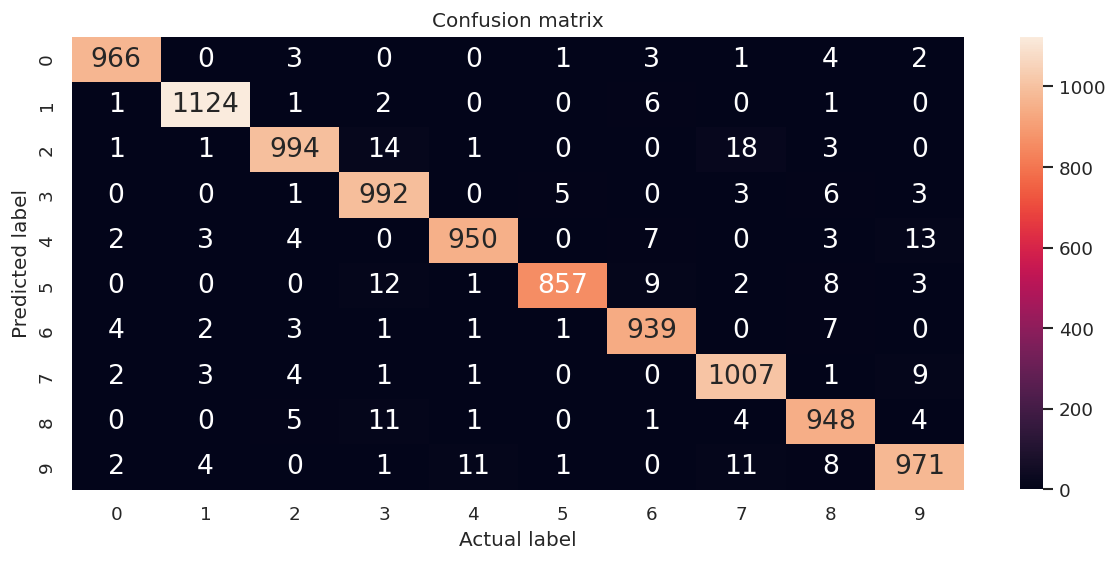

In [14]:
m_name = "MobileNetV2-RAW" ## "ResNet34", "GoogleNet"
if not m_name in os.listdir("."): os.mkdir(m_name)

model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', weights=None)
model = model.to(device)
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Train the model
num_epochs = 15
losses = []
train_accs = []

start = time.time()

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.repeat(1, 3, 1, 1)
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 200 == 199:
            print(datetime.now().strftime("%d/%m/%Y %H:%M:%S"), end=":  ")
            print('[Epoch: %d, Batch: %5d] loss: %.5f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0
    correct = 0.0
    pred = outputs.argmax(dim=1, keepdim=True)
    correct += pred.eq(labels.view_as(pred)).sum().item()
    train_acc = 100. * correct / len(outputs)
    train_accs.append(train_acc)
    losses.append(loss.item())
    writer.add_scalar("Loss/train", loss, epoch)
    writer.add_scalar("Accuracy/train", train_acc, epoch)
    
end = time.time()
duration = round(end-start, 3)
writer.add_scalar("Training Time", duration)
print('Finished Training')
print()

## Saving the Model

torch.save(model, f"./Models/{m_name}")

## Testing the Model

positive, negative = test(model, device, test_loader)

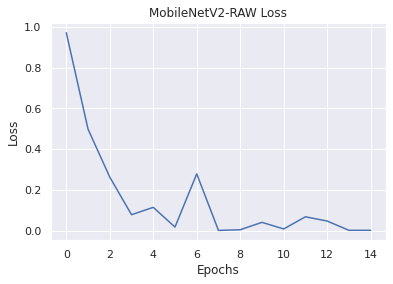

In [15]:
plot_loss(m_name)

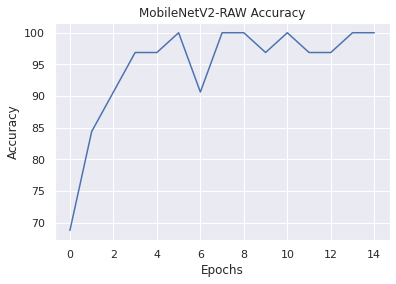

In [16]:
plot_acc(m_name)

In [10]:
total_params = sum(
	param.numel() for param in model.parameters()
)
total_params

3504872

In [8]:
model = torch.load("./Models/MobileNetV2-RAW")

Test set: Average loss: 0.0919, Accuracy: 9748/10000 (97%)

Confusion Matrix:



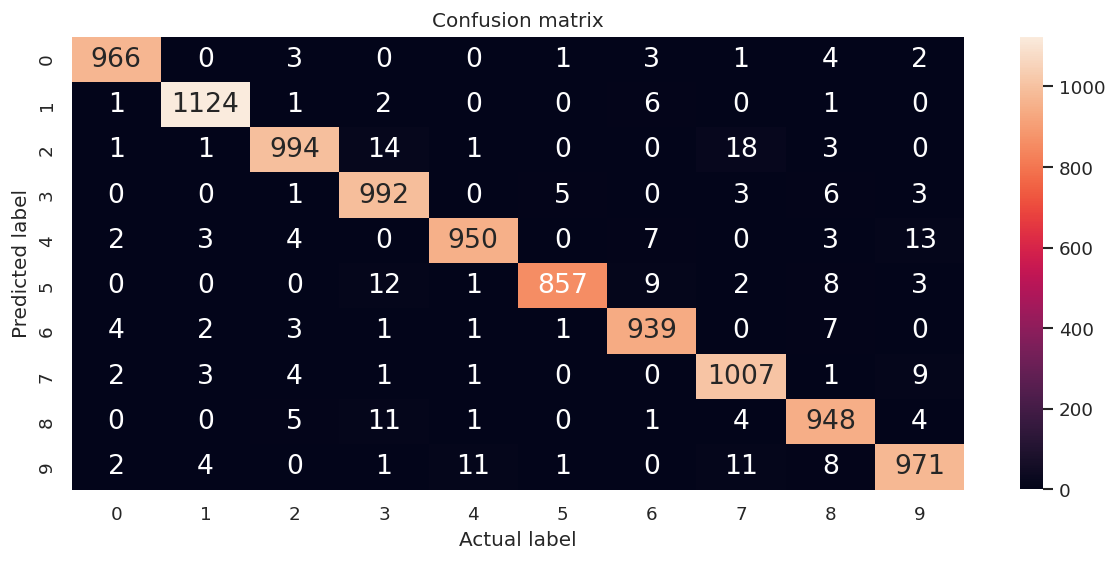

In [25]:
positive, negative = test(model, device, test_loader)

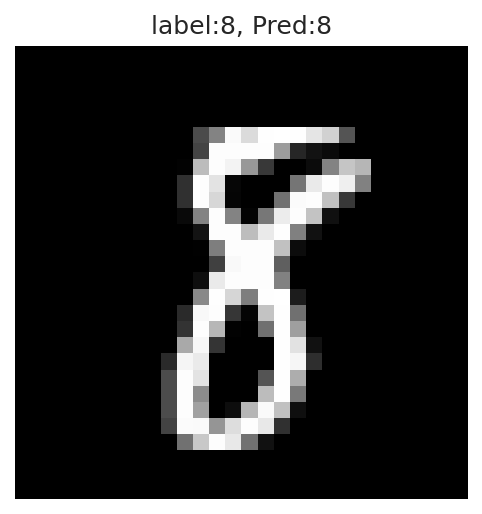

In [51]:
pos_inference(positive,"MobileNetV2-RAW")

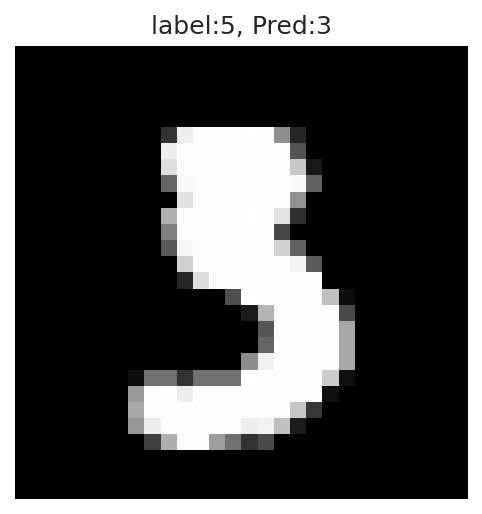

In [52]:
neg_inference(negative, "MobileNetV2-RAW")

#### Dataset = Reduced by Mean

In [25]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (1.)) ## Comment this line when working with RAW dataset and not Reduced Mean one. 
                                          ####  With this line, our model is learning the variance in our dataset other than raw images.
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

Using cache found in /home/jovyan/.cache/torch/hub/pytorch_vision_v0.10.0


05/05/2023 19:02:47:  [Epoch: 1, Batch:   200] loss: 0.57361
05/05/2023 19:02:56:  [Epoch: 1, Batch:   400] loss: 0.33998
05/05/2023 19:03:05:  [Epoch: 1, Batch:   600] loss: 0.26140
05/05/2023 19:03:14:  [Epoch: 1, Batch:   800] loss: 0.21180
05/05/2023 19:03:30:  [Epoch: 2, Batch:   200] loss: 0.13933
05/05/2023 19:03:39:  [Epoch: 2, Batch:   400] loss: 0.11826
05/05/2023 19:03:49:  [Epoch: 2, Batch:   600] loss: 0.10012
05/05/2023 19:03:58:  [Epoch: 2, Batch:   800] loss: 0.09597
05/05/2023 19:04:13:  [Epoch: 3, Batch:   200] loss: 0.06695
05/05/2023 19:04:23:  [Epoch: 3, Batch:   400] loss: 0.06457
05/05/2023 19:04:32:  [Epoch: 3, Batch:   600] loss: 0.05860
05/05/2023 19:04:42:  [Epoch: 3, Batch:   800] loss: 0.05622
05/05/2023 19:04:57:  [Epoch: 4, Batch:   200] loss: 0.04121
05/05/2023 19:05:06:  [Epoch: 4, Batch:   400] loss: 0.04021
05/05/2023 19:05:16:  [Epoch: 4, Batch:   600] loss: 0.04176
05/05/2023 19:05:25:  [Epoch: 4, Batch:   800] loss: 0.03796
05/05/2023 19:05:41:  [E

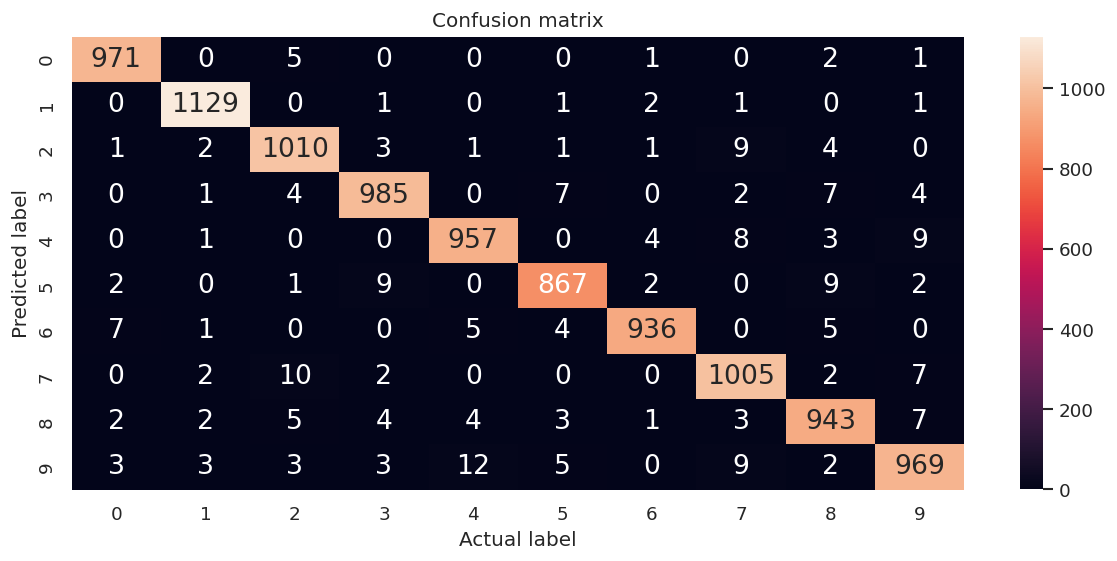

In [21]:
m_name = "MobileNetV2-ReducedMean" ## "ResNet34", "GoogleNet"
if not m_name in os.listdir("."): os.mkdir(m_name)

model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', weights=None)
model = model.to(device)
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Train the model
num_epochs = 15
losses = []
train_accs = []

start = time.time()

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.repeat(1, 3, 1, 1)
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 200 == 199:
            print(datetime.now().strftime("%d/%m/%Y %H:%M:%S"), end=":  ")
            print('[Epoch: %d, Batch: %5d] loss: %.5f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0
    correct = 0.0
    pred = outputs.argmax(dim=1, keepdim=True)
    correct += pred.eq(labels.view_as(pred)).sum().item()
    train_acc = 100. * correct / len(outputs)
    train_accs.append(train_acc)
    losses.append(loss.item())
    writer.add_scalar("Loss/train", loss, epoch)
    writer.add_scalar("Accuracy/train", train_acc, epoch)
    
end = time.time()
duration = round(end-start, 3)
writer.add_scalar("Training Time", duration)
print('Finished Training')
print()

## Saving the Model

torch.save(model, f"./Models/{m_name}")

## Testing the Model

positive, negative = test(model, device, test_loader)

torch.Size([1, 3, 28, 28]) tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0')
Output:  tensor(2, device='cuda:0')


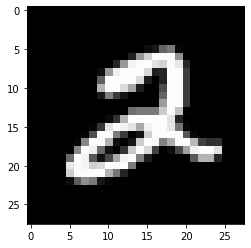

In [52]:
#"MobileNetV2-ReducedMean"
model = torch.load("./Models/MobileNetV2-ReducedMean")
model.eval()

input_image = (train_dataset.data[5].float()/255).repeat(1, 3, 1, 1).to(device)
plt.imshow(train_dataset.data[5].float()/255, cmap="gray")
print(input_image.shape, input_image)
print("Output: ",torch.argmax(model(input_image)))


Test set: Average loss: 0.0873, Accuracy: 9771/10000 (98%)

Confusion Matrix:



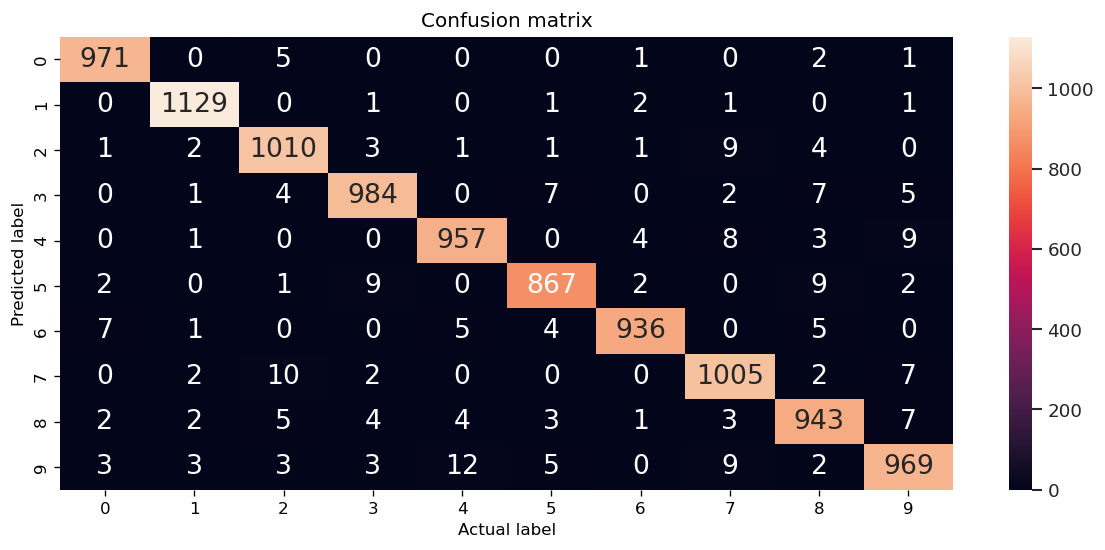

In [53]:
_,_ = test(model, device, test_loader)

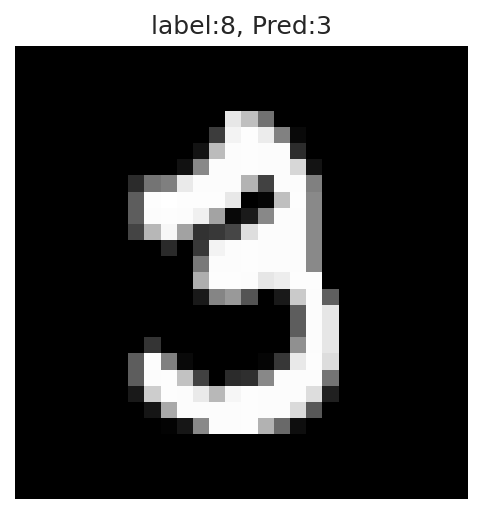

In [58]:
neg_inference(negative,"MobileNetV2-ReducedMean")

### ResNet18

Using cache found in /home/jovyan/.cache/torch/hub/pytorch_vision_v0.10.0


05/05/2023 20:27:25:  [Epoch: 1, Batch:   200] loss: 0.06147
05/05/2023 20:27:31:  [Epoch: 1, Batch:   400] loss: 0.02487
05/05/2023 20:27:37:  [Epoch: 1, Batch:   600] loss: 0.01777
05/05/2023 20:27:42:  [Epoch: 1, Batch:   800] loss: 0.01781
05/05/2023 20:27:51:  [Epoch: 2, Batch:   200] loss: 0.01328
05/05/2023 20:27:57:  [Epoch: 2, Batch:   400] loss: 0.01234
05/05/2023 20:28:03:  [Epoch: 2, Batch:   600] loss: 0.01253
05/05/2023 20:28:09:  [Epoch: 2, Batch:   800] loss: 0.01210
05/05/2023 20:28:18:  [Epoch: 3, Batch:   200] loss: 0.00930
05/05/2023 20:28:24:  [Epoch: 3, Batch:   400] loss: 0.00957
05/05/2023 20:28:30:  [Epoch: 3, Batch:   600] loss: 0.00916
05/05/2023 20:28:36:  [Epoch: 3, Batch:   800] loss: 0.01006
05/05/2023 20:28:45:  [Epoch: 4, Batch:   200] loss: 0.00784
05/05/2023 20:28:51:  [Epoch: 4, Batch:   400] loss: 0.00840
05/05/2023 20:28:56:  [Epoch: 4, Batch:   600] loss: 0.00760
05/05/2023 20:29:02:  [Epoch: 4, Batch:   800] loss: 0.01005
05/05/2023 20:29:11:  [E

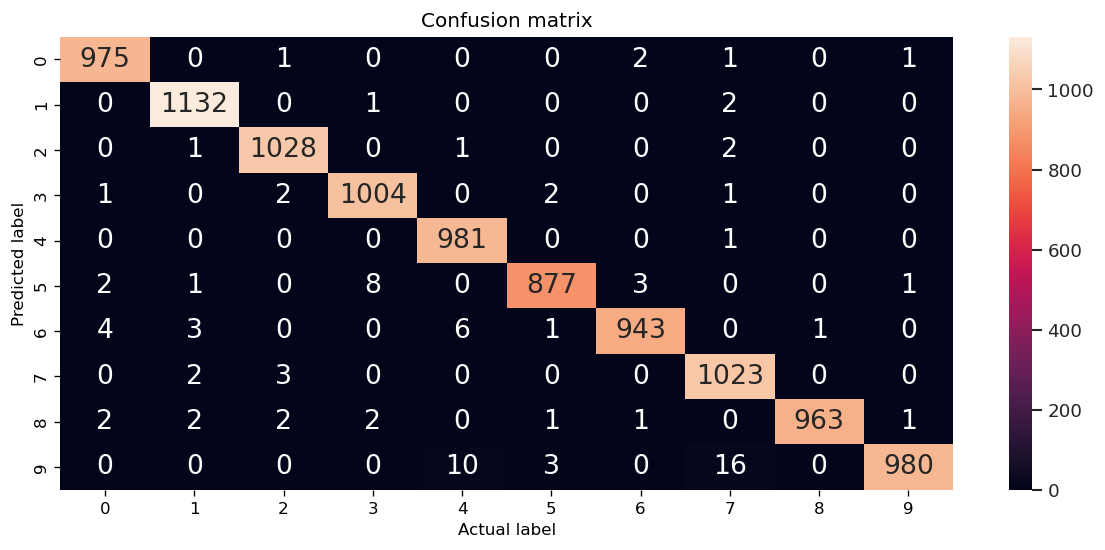

In [8]:

m_name = "ResNet18" ## "ResNet34", "GoogleNet"
if not m_name in os.listdir("."): os.mkdir(m_name)

model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', weights=None)
model = model.to(device)
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 10
losses = []
train_accs = []

start = time.time()

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.repeat(1, 3, 1, 1)
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 200 == 199:
            print(datetime.now().strftime("%d/%m/%Y %H:%M:%S"), end=":  ")
            print('[Epoch: %d, Batch: %5d] loss: %.5f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0
    correct = 0.0
    pred = outputs.argmax(dim=1, keepdim=True)
    correct += pred.eq(labels.view_as(pred)).sum().item()
    train_acc = 100. * correct / len(outputs)
    train_accs.append(train_acc)
    losses.append(loss.item())
    writer.add_scalar("Loss/train", loss, epoch)
    writer.add_scalar("Accuracy/train", train_acc, epoch)
    
end = time.time()
duration = round(end-start, 3)
writer.add_scalar("Training Time", duration)
print('Finished Training')
print()

## Saving the Model

torch.save(model, f"./Models/{m_name}")

## Testing the Model

positive, negative = test(model, device, test_loader)

Test set: Average loss: 0.0307, Accuracy: 9906/10000 (99%)

Confusion Matrix:



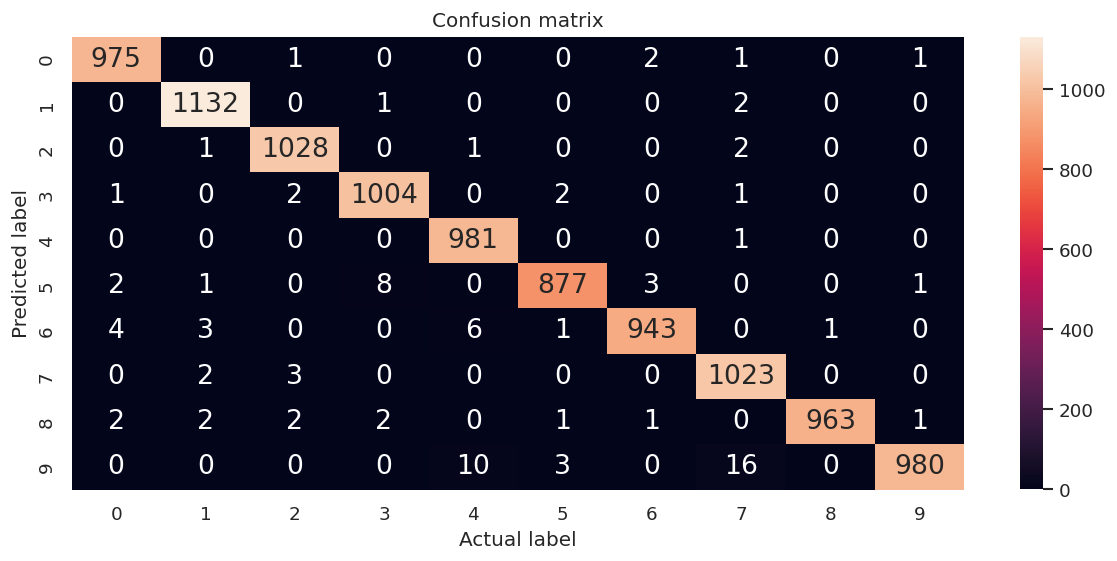

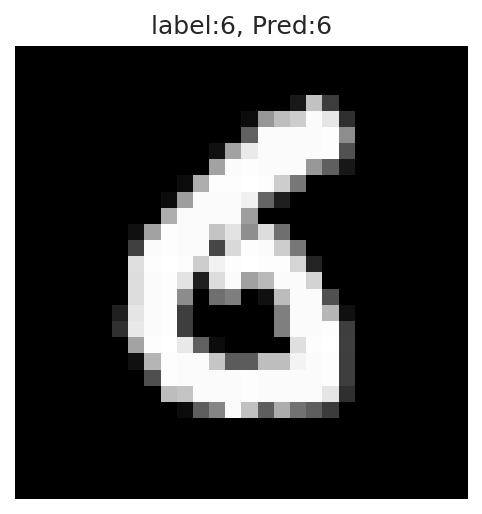

In [59]:
model = torch.load("./Models/ResNet18")
positive, negative = test(model, device, test_loader)
pos_inference(positive,"ResNet18")

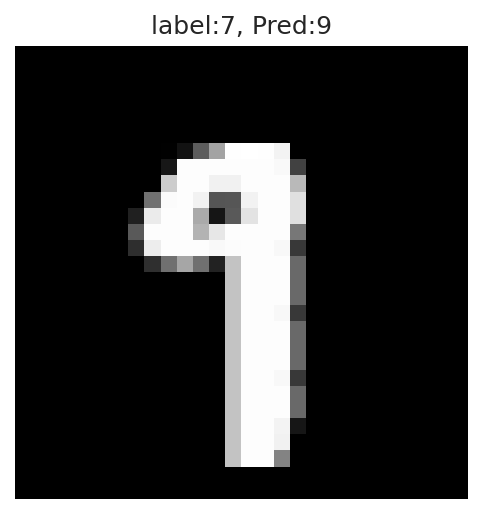

In [60]:
neg_inference(negative, "ResNet18")

### GoogLeNet

Using cache found in /home/jovyan/.cache/torch/hub/pytorch_vision_v0.10.0


05/05/2023 19:41:32:  [Epoch: 1, Batch:   200] loss: 0.12365
05/05/2023 19:41:43:  [Epoch: 1, Batch:   400] loss: 0.04479
05/05/2023 19:41:54:  [Epoch: 1, Batch:   600] loss: 0.04544
05/05/2023 19:42:05:  [Epoch: 1, Batch:   800] loss: 0.02916
05/05/2023 19:42:24:  [Epoch: 2, Batch:   200] loss: 0.02252
05/05/2023 19:42:35:  [Epoch: 2, Batch:   400] loss: 0.02002
05/05/2023 19:42:47:  [Epoch: 2, Batch:   600] loss: 0.02263
05/05/2023 19:42:58:  [Epoch: 2, Batch:   800] loss: 0.01935
05/05/2023 19:43:17:  [Epoch: 3, Batch:   200] loss: 0.01490
05/05/2023 19:43:28:  [Epoch: 3, Batch:   400] loss: 0.02142
05/05/2023 19:43:40:  [Epoch: 3, Batch:   600] loss: 0.01566
05/05/2023 19:43:51:  [Epoch: 3, Batch:   800] loss: 0.01748
05/05/2023 19:44:11:  [Epoch: 4, Batch:   200] loss: 0.01364
05/05/2023 19:44:22:  [Epoch: 4, Batch:   400] loss: 0.01650
05/05/2023 19:44:34:  [Epoch: 4, Batch:   600] loss: 0.01700
05/05/2023 19:44:45:  [Epoch: 4, Batch:   800] loss: 0.01200
05/05/2023 19:45:05:  [E

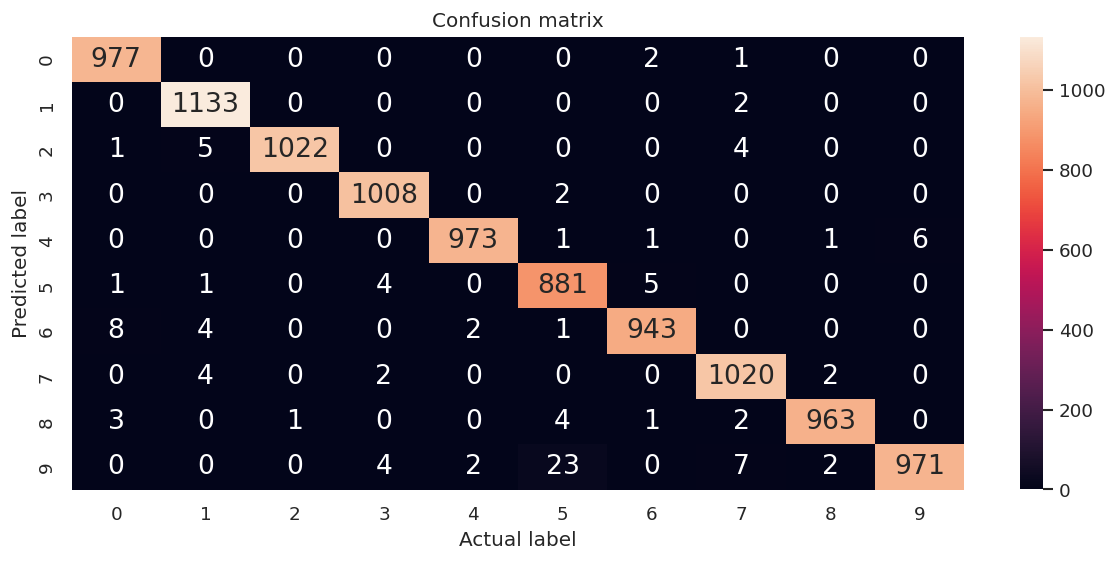

In [26]:

m_name = "GoogLeNet" ## "ResNet34", "GoogleNet"
if not m_name in os.listdir("."): os.mkdir(m_name)
del model
model = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', init_weights=True)
model = model.to(device)
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 10
losses = []
train_accs = []

start = time.time()

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.repeat(1, 3, 1, 1)
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 200 == 199:
            print(datetime.now().strftime("%d/%m/%Y %H:%M:%S"), end=":  ")
            print('[Epoch: %d, Batch: %5d] loss: %.5f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0
    correct = 0.0
    pred = outputs.argmax(dim=1, keepdim=True)
    correct += pred.eq(labels.view_as(pred)).sum().item()
    train_acc = 100. * correct / len(outputs)
    train_accs.append(train_acc)
    losses.append(loss.item())
    writer.add_scalar("Loss/train", loss, epoch)
    writer.add_scalar("Accuracy/train", train_acc, epoch)
    
end = time.time()
duration = round(end-start, 3)
writer.add_scalar("Training Time", duration)
print('Finished Training')
print()

## Saving the Model

torch.save(model, f"./Models/{m_name}")

## Testing the Model

positive, negative = test(model, device, test_loader)

Test set: Average loss: 0.0369, Accuracy: 9911/10000 (99%)

Confusion Matrix:



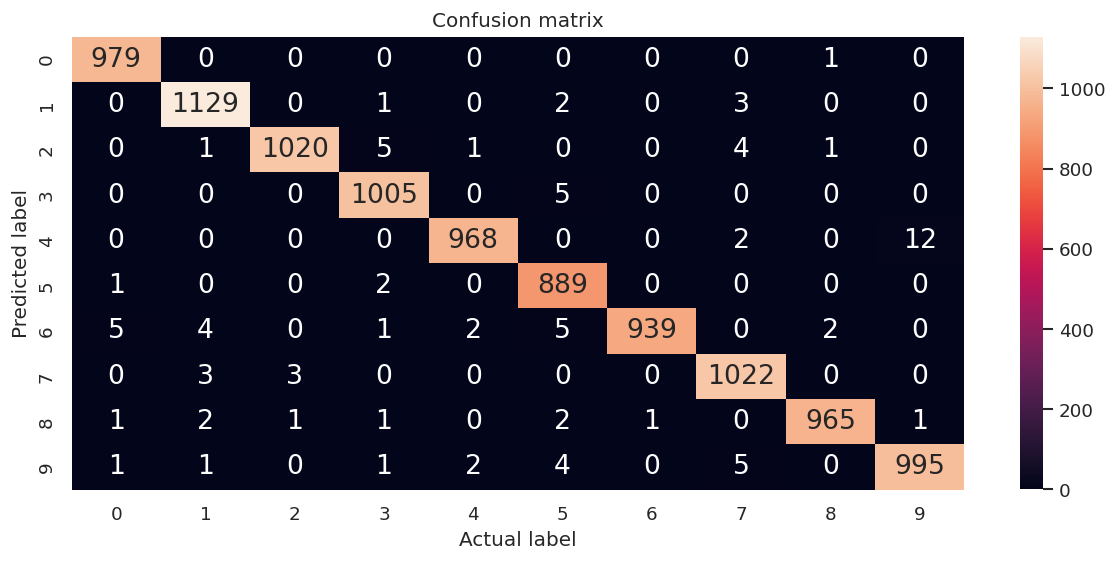

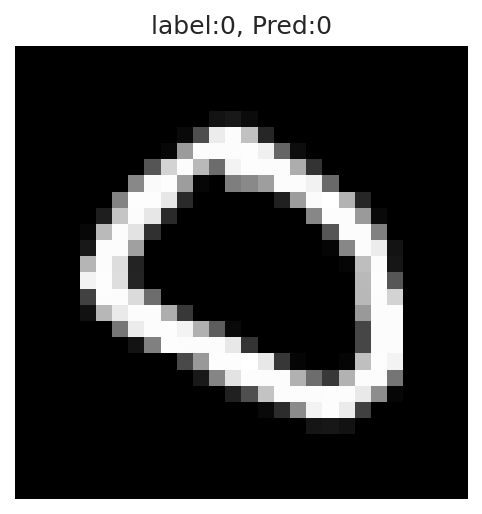

In [61]:
model = torch.load("./Models/GoogLeNet")
positive, negative = test(model, device, test_loader)
pos_inference(positive,"GoogLeNet")

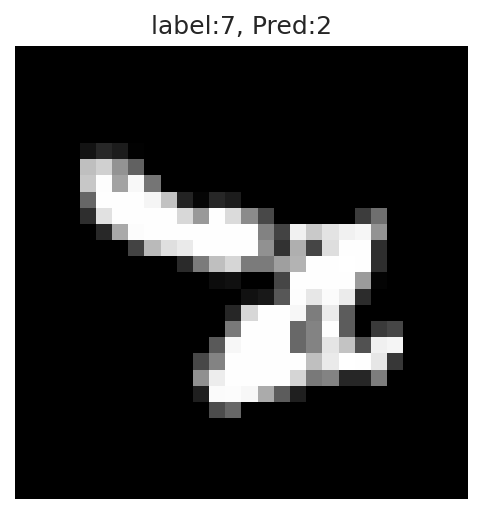

In [62]:
neg_inference(negative, "GoogLeNet")

## Training on CIFAR 10

### MobileNetV2 RAW Dataset

In [9]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    all_labels = torch.Tensor([])
    all_pred = torch.Tensor([])
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            all_labels = torch.cat([all_labels, labels.cpu()])
            output = model(data)
            test_loss += F.cross_entropy(output, labels, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            all_pred = torch.cat([all_pred, pred.cpu()])
            correct += pred.eq(labels.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc = 100. * correct / len(test_loader.dataset)
    writer.add_scalar("Loss/test", test_loss)
    writer.add_scalar("Accuracy/test", test_acc)
    
    writer.flush()
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),test_acc))
    confusion_matrix = cm(all_labels.cpu(), all_pred.cpu())
    print("Confusion Matrix:\n") 
    plot_confusion_matrix(confusion_matrix)
    writer.close()

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor()
    # transforms.Normalize((0.5, 0.5, 0.5), (1., 1., 1.)) ## Comment this line when working with RAW dataset and not Reduced Mean one. 
                                          ####  With this line, our model is learning the variance in our dataset other than raw images.
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


Using cache found in /home/jovyan/.cache/torch/hub/pytorch_vision_v0.10.0


07/05/2023 15:26:39:  [Epoch: 1, Batch:   200] loss: 0.46383
07/05/2023 15:26:49:  [Epoch: 1, Batch:   400] loss: 0.39922
07/05/2023 15:26:59:  [Epoch: 1, Batch:   600] loss: 0.37914
07/05/2023 15:27:09:  [Epoch: 1, Batch:   800] loss: 0.36018
07/05/2023 15:27:18:  [Epoch: 1, Batch:  1000] loss: 0.35192
07/05/2023 15:27:28:  [Epoch: 1, Batch:  1200] loss: 0.34331
07/05/2023 15:27:38:  [Epoch: 1, Batch:  1400] loss: 0.33641
07/05/2023 15:27:56:  [Epoch: 2, Batch:   200] loss: 0.31557
07/05/2023 15:28:05:  [Epoch: 2, Batch:   400] loss: 0.31347
07/05/2023 15:28:16:  [Epoch: 2, Batch:   600] loss: 0.31164
07/05/2023 15:28:26:  [Epoch: 2, Batch:   800] loss: 0.30573
07/05/2023 15:28:36:  [Epoch: 2, Batch:  1000] loss: 0.30393
07/05/2023 15:28:46:  [Epoch: 2, Batch:  1200] loss: 0.30097
07/05/2023 15:28:56:  [Epoch: 2, Batch:  1400] loss: 0.29529
07/05/2023 15:29:14:  [Epoch: 3, Batch:   200] loss: 0.28402
07/05/2023 15:29:24:  [Epoch: 3, Batch:   400] loss: 0.27782
07/05/2023 15:29:34:  [E

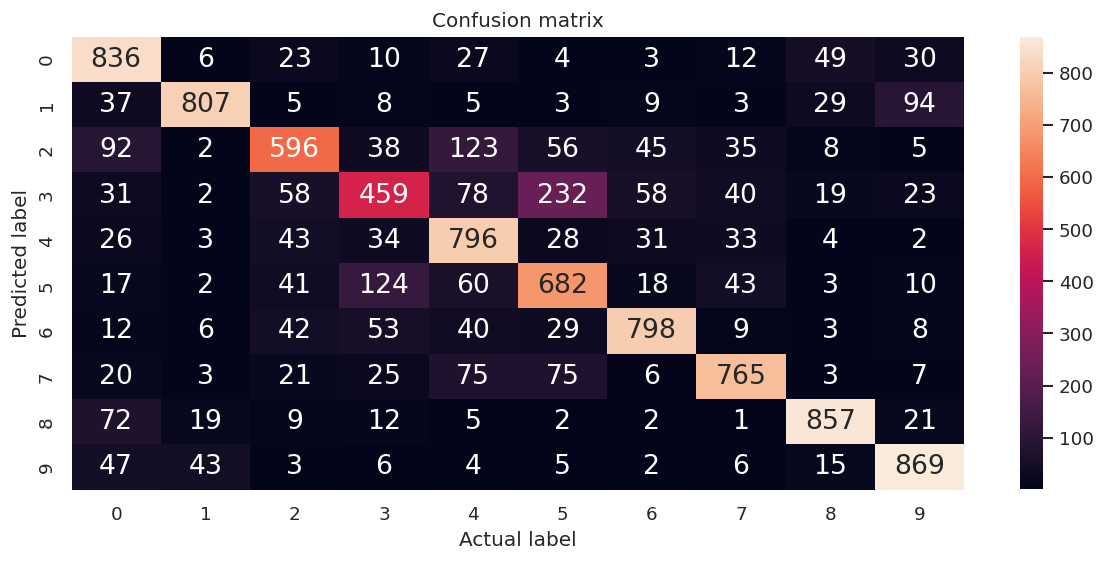

In [25]:
m_name = "MobileNetV2-RAW-CIFAR10" ## "ResNet34", "GoogleNet"
if not m_name in os.listdir("."): os.mkdir(m_name)

model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', weights=None)
model = model.to(device)
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 15
losses = []
train_accs = []

start = time.time()

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 200 == 199:
            print(datetime.now().strftime("%d/%m/%Y %H:%M:%S"), end=":  ")
            print('[Epoch: %d, Batch: %5d] loss: %.5f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0
    correct = 0.0
    pred = outputs.argmax(dim=1, keepdim=True)
    correct += pred.eq(labels.view_as(pred)).sum().item()
    train_acc = 100. * correct / len(outputs)
    train_accs.append(train_acc)
    losses.append(loss.item())
    writer.add_scalar("Loss/train", loss, epoch)
    writer.add_scalar("Accuracy/train", train_acc, epoch)
    
end = time.time()
duration = round(end-start, 3)
writer.add_scalar("Training Time", duration)
print('Finished Training')
print()

## Saving the Model

torch.save(model, f"./Models/{m_name}")

## Testing the Model

test(model, device, test_loader)

### MobileNetV2 ReducedMean Dataset

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (1., 1., 1.)) ## Comment this line when working with RAW dataset and not Reduced Mean one. 
                                          ####  With this line, our model is learning the variance in our dataset other than raw images.
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


Using cache found in /home/jovyan/.cache/torch/hub/pytorch_vision_v0.10.0


07/05/2023 15:45:45:  [Epoch: 1, Batch:   200] loss: 0.48051
07/05/2023 15:45:56:  [Epoch: 1, Batch:   400] loss: 0.40798
07/05/2023 15:46:07:  [Epoch: 1, Batch:   600] loss: 0.37921
07/05/2023 15:46:17:  [Epoch: 1, Batch:   800] loss: 0.36505
07/05/2023 15:46:28:  [Epoch: 1, Batch:  1000] loss: 0.35346
07/05/2023 15:46:37:  [Epoch: 1, Batch:  1200] loss: 0.34846
07/05/2023 15:46:48:  [Epoch: 1, Batch:  1400] loss: 0.33808
07/05/2023 15:47:07:  [Epoch: 2, Batch:   200] loss: 0.32003
07/05/2023 15:47:17:  [Epoch: 2, Batch:   400] loss: 0.32129
07/05/2023 15:47:28:  [Epoch: 2, Batch:   600] loss: 0.30963
07/05/2023 15:47:37:  [Epoch: 2, Batch:   800] loss: 0.30703
07/05/2023 15:47:48:  [Epoch: 2, Batch:  1000] loss: 0.30804
07/05/2023 15:47:58:  [Epoch: 2, Batch:  1200] loss: 0.30600
07/05/2023 15:48:09:  [Epoch: 2, Batch:  1400] loss: 0.29744
07/05/2023 15:48:27:  [Epoch: 3, Batch:   200] loss: 0.28560
07/05/2023 15:48:37:  [Epoch: 3, Batch:   400] loss: 0.27987
07/05/2023 15:48:47:  [E

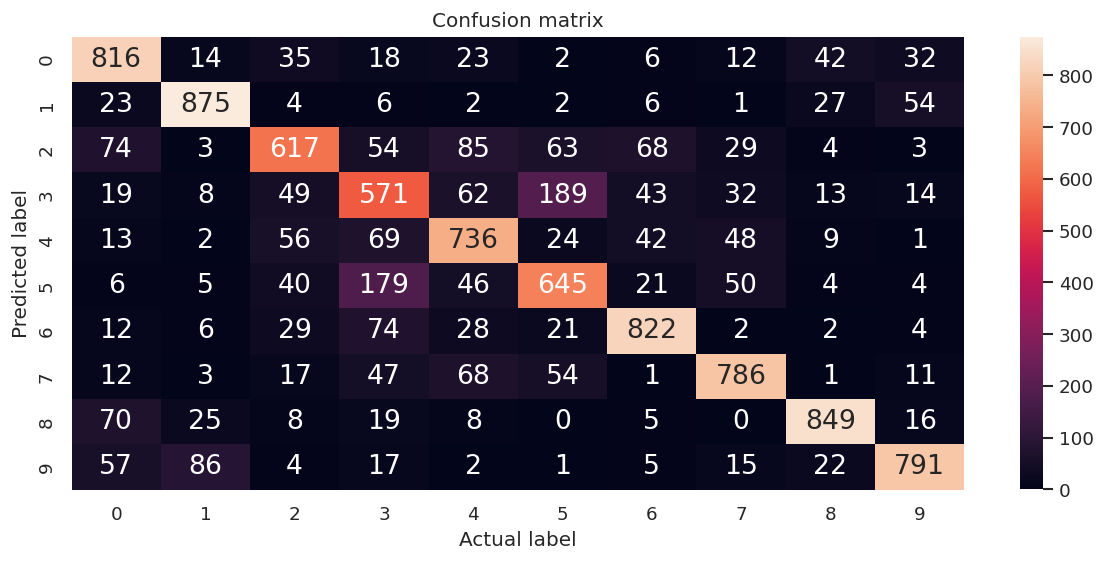

In [27]:
m_name = "MobileNetV2-RM-CIFAR10" ## "ResNet34", "GoogleNet"
if not m_name in os.listdir("."): os.mkdir(m_name)

model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', weights=None)
model = model.to(device)
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 15
losses = []
train_accs = []

start = time.time()

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 200 == 199:
            print(datetime.now().strftime("%d/%m/%Y %H:%M:%S"), end=":  ")
            print('[Epoch: %d, Batch: %5d] loss: %.5f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0
    correct = 0.0
    pred = outputs.argmax(dim=1, keepdim=True)
    correct += pred.eq(labels.view_as(pred)).sum().item()
    train_acc = 100. * correct / len(outputs)
    train_accs.append(train_acc)
    losses.append(loss.item())
    writer.add_scalar("Loss/train", loss, epoch)
    writer.add_scalar("Accuracy/train", train_acc, epoch)
    
end = time.time()
duration = round(end-start, 3)
writer.add_scalar("Training Time", duration)
print('Finished Training')
print()

## Saving the Model

torch.save(model, f"./Models/{m_name}")

## Testing the Model

test(model, device, test_loader)

### ResNet18 Epoch=5 

Using cache found in /home/jovyan/.cache/torch/hub/pytorch_vision_v0.10.0


07/05/2023 14:25:19:  [Epoch: 1, Batch:   200] loss: 0.41750
07/05/2023 14:25:26:  [Epoch: 1, Batch:   400] loss: 0.33219
07/05/2023 14:25:33:  [Epoch: 1, Batch:   600] loss: 0.29659
07/05/2023 14:25:48:  [Epoch: 2, Batch:   200] loss: 0.25175
07/05/2023 14:25:55:  [Epoch: 2, Batch:   400] loss: 0.23702
07/05/2023 14:26:02:  [Epoch: 2, Batch:   600] loss: 0.22303
07/05/2023 14:26:16:  [Epoch: 3, Batch:   200] loss: 0.20187
07/05/2023 14:26:24:  [Epoch: 3, Batch:   400] loss: 0.19123
07/05/2023 14:26:31:  [Epoch: 3, Batch:   600] loss: 0.18332
07/05/2023 14:26:45:  [Epoch: 4, Batch:   200] loss: 0.16243
07/05/2023 14:26:52:  [Epoch: 4, Batch:   400] loss: 0.15618
07/05/2023 14:26:58:  [Epoch: 4, Batch:   600] loss: 0.16259
07/05/2023 14:27:12:  [Epoch: 5, Batch:   200] loss: 0.13726
07/05/2023 14:27:20:  [Epoch: 5, Batch:   400] loss: 0.13914
07/05/2023 14:27:28:  [Epoch: 5, Batch:   600] loss: 0.13679
Finished Training

Test set: Average loss: 0.8050, Accuracy: 7247/10000 (72%)

Confus

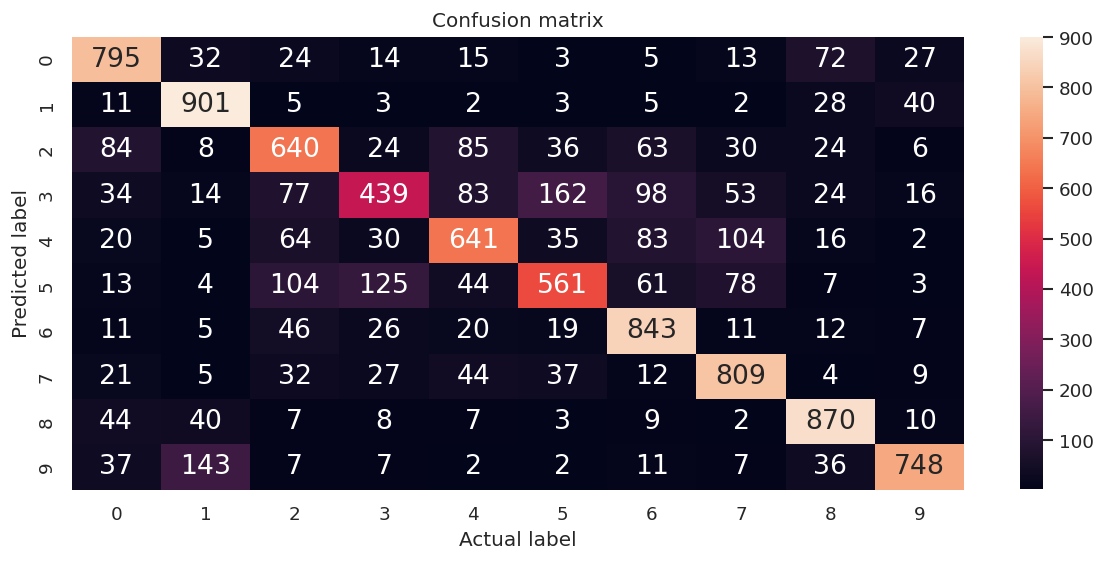

In [18]:

m_name = "ResNet18-CIFAR10" ## "ResNet34", "GoogleNet"
if not m_name in os.listdir("."): os.mkdir(m_name)

model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', weights=None)
model = model.to(device)
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train the model
num_epochs = 5
losses = []
train_accs = []

start = time.time()

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 200 == 199:
            print(datetime.now().strftime("%d/%m/%Y %H:%M:%S"), end=":  ")
            print('[Epoch: %d, Batch: %5d] loss: %.5f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0
    correct = 0.0
    pred = outputs.argmax(dim=1, keepdim=True)
    correct += pred.eq(labels.view_as(pred)).sum().item()
    train_acc = 100. * correct / len(outputs)
    train_accs.append(train_acc)
    losses.append(loss.item())
    writer.add_scalar("Loss/train", loss, epoch)
    writer.add_scalar("Accuracy/train", train_acc, epoch)
    
end = time.time()
duration = round(end-start, 3)
writer.add_scalar("Training Time", duration)
print('Finished Training')
print()

## Saving the Model

torch.save(model, f"./Models/{m_name}")

## Testing the Model

test(model, device, test_loader)

### ResNet18 Epoch=10

Using cache found in /home/jovyan/.cache/torch/hub/pytorch_vision_v0.10.0


07/05/2023 14:33:02:  [Epoch: 1, Batch:   200] loss: 0.42903
07/05/2023 14:33:10:  [Epoch: 1, Batch:   400] loss: 0.34201
07/05/2023 14:33:17:  [Epoch: 1, Batch:   600] loss: 0.30290
07/05/2023 14:33:31:  [Epoch: 2, Batch:   200] loss: 0.25670
07/05/2023 14:33:38:  [Epoch: 2, Batch:   400] loss: 0.23940
07/05/2023 14:33:45:  [Epoch: 2, Batch:   600] loss: 0.22389
07/05/2023 14:34:00:  [Epoch: 3, Batch:   200] loss: 0.19540
07/05/2023 14:34:08:  [Epoch: 3, Batch:   400] loss: 0.19331
07/05/2023 14:34:16:  [Epoch: 3, Batch:   600] loss: 0.18344
07/05/2023 14:34:31:  [Epoch: 4, Batch:   200] loss: 0.15794
07/05/2023 14:34:39:  [Epoch: 4, Batch:   400] loss: 0.16084
07/05/2023 14:34:46:  [Epoch: 4, Batch:   600] loss: 0.15480
07/05/2023 14:35:01:  [Epoch: 5, Batch:   200] loss: 0.13310
07/05/2023 14:35:09:  [Epoch: 5, Batch:   400] loss: 0.13649
07/05/2023 14:35:16:  [Epoch: 5, Batch:   600] loss: 0.13755
07/05/2023 14:35:30:  [Epoch: 6, Batch:   200] loss: 0.11508
07/05/2023 14:35:37:  [E

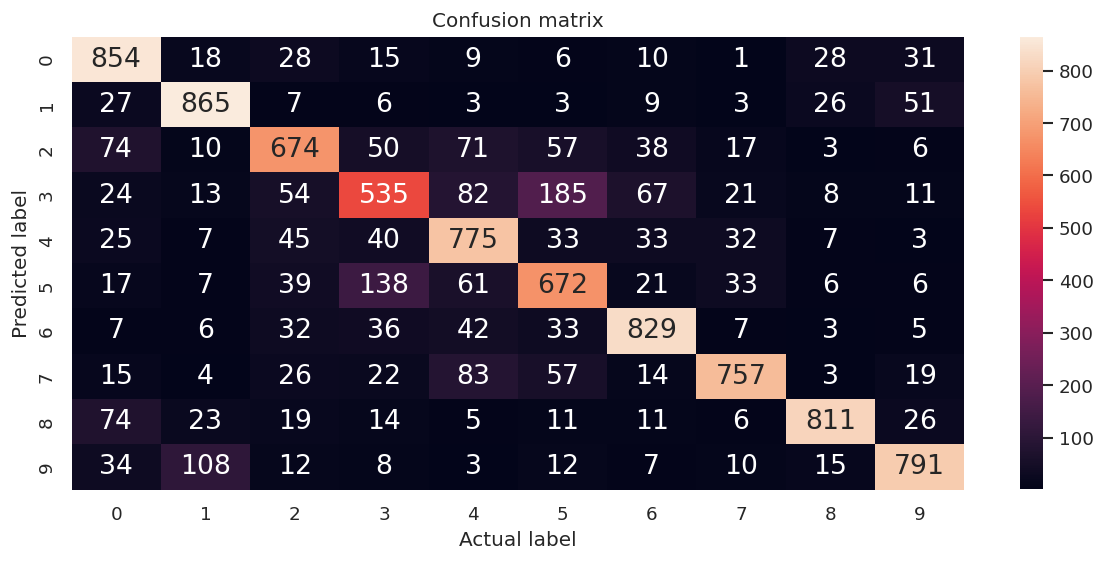

In [19]:

m_name = "ResNet18-CIFAR10" ## "ResNet34", "GoogleNet"
if not m_name in os.listdir("."): os.mkdir(m_name)

model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', weights=None)
model = model.to(device)
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train the model
num_epochs = 10
losses = []
train_accs = []

start = time.time()

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 200 == 199:
            print(datetime.now().strftime("%d/%m/%Y %H:%M:%S"), end=":  ")
            print('[Epoch: %d, Batch: %5d] loss: %.5f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0
    correct = 0.0
    pred = outputs.argmax(dim=1, keepdim=True)
    correct += pred.eq(labels.view_as(pred)).sum().item()
    train_acc = 100. * correct / len(outputs)
    train_accs.append(train_acc)
    losses.append(loss.item())
    writer.add_scalar("Loss/train", loss, epoch)
    writer.add_scalar("Accuracy/train", train_acc, epoch)
    
end = time.time()
duration = round(end-start, 3)
writer.add_scalar("Training Time", duration)
print('Finished Training')
print()

## Saving the Model

torch.save(model, f"./Models/{m_name}")

## Testing the Model

test(model, device, test_loader)

### GoogLeNet

Using cache found in /home/jovyan/.cache/torch/hub/pytorch_vision_v0.10.0


07/05/2023 16:11:16:  [Epoch: 1, Batch:   200] loss: 0.54942
07/05/2023 16:11:30:  [Epoch: 1, Batch:   400] loss: 0.47797
07/05/2023 16:11:44:  [Epoch: 1, Batch:   600] loss: 0.42649
07/05/2023 16:11:58:  [Epoch: 1, Batch:   800] loss: 0.40039
07/05/2023 16:12:12:  [Epoch: 1, Batch:  1000] loss: 0.38343
07/05/2023 16:12:27:  [Epoch: 1, Batch:  1200] loss: 0.37843
07/05/2023 16:12:41:  [Epoch: 1, Batch:  1400] loss: 0.43371
07/05/2023 16:13:07:  [Epoch: 2, Batch:   200] loss: 0.39173
07/05/2023 16:13:21:  [Epoch: 2, Batch:   400] loss: 0.39343
07/05/2023 16:13:35:  [Epoch: 2, Batch:   600] loss: 0.39319
07/05/2023 16:13:49:  [Epoch: 2, Batch:   800] loss: 0.39385
07/05/2023 16:14:04:  [Epoch: 2, Batch:  1000] loss: 0.37726
07/05/2023 16:14:18:  [Epoch: 2, Batch:  1200] loss: 0.37186
07/05/2023 16:14:32:  [Epoch: 2, Batch:  1400] loss: 0.37049
07/05/2023 16:14:58:  [Epoch: 3, Batch:   200] loss: 0.35834
07/05/2023 16:15:12:  [Epoch: 3, Batch:   400] loss: 0.34741
07/05/2023 16:15:26:  [E

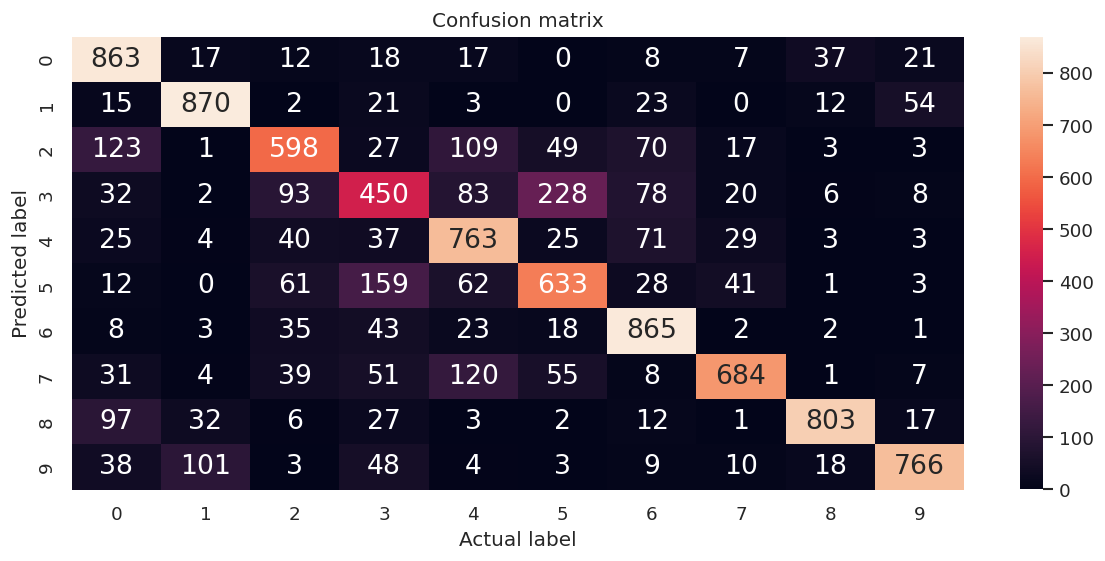

In [28]:

m_name = "GoogLeNet-CIFAR10" ## "ResNet34", "GoogleNet"
if not m_name in os.listdir("."): os.mkdir(m_name)
del model
model = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', init_weights=True)
model = model.to(device)
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train the model
num_epochs = 10
losses = []
train_accs = []

start = time.time()

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 200 == 199:
            print(datetime.now().strftime("%d/%m/%Y %H:%M:%S"), end=":  ")
            print('[Epoch: %d, Batch: %5d] loss: %.5f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0
    correct = 0.0
    pred = outputs.argmax(dim=1, keepdim=True)
    correct += pred.eq(labels.view_as(pred)).sum().item()
    train_acc = 100. * correct / len(outputs)
    train_accs.append(train_acc)
    losses.append(loss.item())
    writer.add_scalar("Loss/train", loss, epoch)
    writer.add_scalar("Accuracy/train", train_acc, epoch)
    
end = time.time()
duration = round(end-start, 3)
writer.add_scalar("Training Time", duration)
print('Finished Training')
print()

## Saving the Model

torch.save(model, f"./Models/{m_name}")

## Testing the Model

test(model, device, test_loader)